In [32]:
%%capture 
!python3 -m pip install google.cloud
!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install pyarrow

In [200]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import pyarrow
import matplotlib.pyplot as plt 

In [3]:
# CONFIGURE THE BIGQUERY SETTINGS

BIGQUERY_PROJECT = 'ironhacks-covid19-data'
BIGQUERY_KEYPATH = 'service-account.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)
# bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=BIGQUERY_KEYPATH)

In [87]:
query = """
SELECT *
FROM `ironhacks_covid19_competition`.`weekly_patterns`
"""

# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
weekly_pattern_orignal = query_job.to_dataframe()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [88]:
# THEN WORK BELOW TO DO SOMETHING THE RESULTS
print("Columns:")
print(weekly_pattern_orignal.shape)
print("\nResults:")
weekly_pattern_orignal.head()

Columns:
(51731, 16)

Results:


,poi_id,location_name,latitude,longitude,city,postal_code,brands,top_category,NAICS,week_number,date_start,raw_visit_counts,visits_concentration,poi_cbg,distance_from_home,median_dwell
0,6a2d40f8-c477-49b6-a5d5-69c31f001afc,Auto Express,40.367561,-86.868565,Lafayette,47909,None,None,None,11,2020-03-16,23,510.40,181570016001,5834.0,109.0
1,49636347-5a9d-4bf3-9d9a-c21a4ba7d8f1,Del Real Auto Connection,40.438210,-86.859945,Lafayette,47904,None,None,None,11,2020-03-16,9,1111.11,181570003001,4914.0,21.0
2,d98b37cd-ed64-456c-b580-c2c299c9f6d6,Bear's Auto Sales,40.409919,-86.869882,Lafayette,47904,None,None,None,11,2020-03-16,11,1074.38,181570012001,2982.0,40.0
3,efb4f5e7-28c2-47be-9d47-254280b8458e,Gta Auto Sales,40.440608,-86.877960,Lafayette,47904,None,None,None,11,2020-03-16,2,5000.00,181570001002,0.0,171.0
4,16f4e696-2065-4854-8ba6-a8cab2b67bf7,Steve Firestone Auto Sales,40.439060,-86.880571,Lafayette,47904,None,None,None,11,2020-03-16,22,495.87,181570001002,2809.0,117.0


## Clean Weekly_Patterns data
1. Remove outliers in distance_from_home.
    - Remove all that are >= 80 KM
    - Impute the values of 0 using median
2. Choose top 10 NAICS catigories

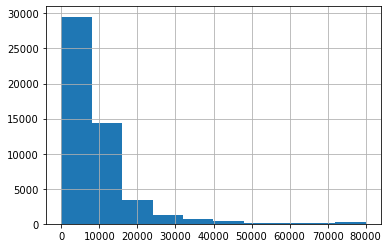

In [89]:
weekly_pattern=weekly_pattern_orignal.loc[weekly_pattern_orignal['distance_from_home']<80000]
# histogram before imputation
weekly_pattern['distance_from_home'].hist();

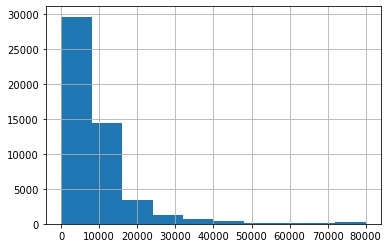

In [90]:
# impute 0 using median
weekly_pattern = weekly_pattern.replace({'distance_from_home':{0:weekly_pattern['distance_from_home'].median()}})
weekly_pattern['distance_from_home'].hist();

In [47]:
weekly_pattern[weekly_pattern['NAICS'].isnull()]

,poi_id,location_name,latitude,longitude,city,postal_code,brands,top_category,NAICS,week_number,date_start,raw_visit_counts,visits_concentration,poi_cbg,distance_from_home,median_dwell
0,6a2d40f8-c477-49b6-a5d5-69c31f001afc,Auto Express,40.367561,-86.868565,Lafayette,47909,None,None,None,11,2020-03-16,23,510.40,181570016001,5834.0,109.0
1,49636347-5a9d-4bf3-9d9a-c21a4ba7d8f1,Del Real Auto Connection,40.438210,-86.859945,Lafayette,47904,None,None,None,11,2020-03-16,9,1111.11,181570003001,4914.0,21.0
2,d98b37cd-ed64-456c-b580-c2c299c9f6d6,Bear's Auto Sales,40.409919,-86.869882,Lafayette,47904,None,None,None,11,2020-03-16,11,1074.38,181570012001,2982.0,40.0
3,efb4f5e7-28c2-47be-9d47-254280b8458e,Gta Auto Sales,40.440608,-86.877960,Lafayette,47904,None,None,None,11,2020-03-16,2,5000.00,181570001002,6888.0,171.0
4,16f4e696-2065-4854-8ba6-a8cab2b67bf7,Steve Firestone Auto Sales,40.439060,-86.880571,Lafayette,47904,None,None,None,11,2020-03-16,22,495.87,181570001002,2809.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49931,16f4e696-2065-4854-8ba6-a8cab2b67bf7,Steve Firestone Auto Sales,40.439060,-86.880571,Lafayette,47904,None,None,None,43,2020-10-26,31,364.20,181570001002,3327.0,45.0
49932,156f82b5-cba9-4a2a-b8ac-4b5cb206d27d,Rohrman Bob Automotive Group,40.408087,-86.857272,Lafayette,47905,None,None,None,43,2020-10-26,68,298.44,181570018002,19232.0,63.5
49933,7137f730-7aaa-4d32-9e05-fa02ba002055,Right Choice Autos,40.424286,-86.855374,Lafayette,47905,None,None,None,43,2020-10-26,27,480.11,181570018002,9567.0,11.0
49934,d529d940-f0d7-4938-93a0-dd90ba83d3f5,McCarty Motors,40.402522,-86.853358,Lafayette,47905,None,None,None,43,2020-10-26,3,3333.33,181570017001,6888.0,14.0


In [20]:
for column in list(weekly_pattern.columns):
    print(weekly_pattern[column].value_counts())

9c585b2b-d970-4892-9a1c-1cbb93a7fda8    31
8867a764-05fd-4014-b05c-1ad8de937ada    31
11bba9ec-d2f9-44ab-ac4d-84b9654fc011    31
888b10da-350a-4184-8a95-d27cc13dd69f    31
18ee6242-1a48-4a17-b58e-bbc651fa0468    31
                                        ..
67dfe851-d702-494b-9ee6-e68c836dcf84     4
9ea86083-43d8-43b0-b014-3136616c32b7     4
2d4ebc33-75c8-4822-a48d-57401f36ddfc     4
b5bbc683-775d-4fb5-b120-1c304302e136     4
77baea34-296d-4f0f-9b0b-1e191233101a     4
Name: poi_id, Length: 1804, dtype: int64
Subway                                    384
Marathon                                  372
IU Health                                 335
Dollar General                            328
Starbucks                                 310
                                         ... 
Habitat for Humanity ReStore                1
Mercedes Benz of Lafayette                  1
Bob Rohrman Hyundai                         1
Lueken Chiropractic and Wellness Group      1
Spitzer Court             

## Get the moving average of all the visit numbers to predict week 44. 
The following code takes a long time to execute since it loops 1804 times. The results of 3-day moving average have already been calculated to saved in a csv. No need to run it unless the moving average period needs to be changed. The result can be directly loaded from the csv

In [ ]:
query = """
    select *
    from ironhacks_covid19_competition.weekly_patterns as a
    join ironhacks_covid19_competition.covid19_cases as b
    join 
    on a.week_number = b.week_number
    LINIT 50
"""
# df = df.loc[df['Artist'] == "Accept"]

# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [270]:
# Moving Average model with period=3
all_poi = weekly_pattern['poi_id'].unique()
pred_df = pd.DataFrame(all_poi, columns=['poi_id'])
pred_df['week_number'] = 44
pred_df['raw_visit_counts'] = np.nan
pred_df['visits_concentration'] = np.nan
pred_df['distance_from_home'] = np.nan
pred_df['median_dwell'] = np.nan
pred_df['date_start'] = '2020-11-02'
temp=None
temp=weekly_pattern.append(pred_df, ignore_index=True)

for poi in all_poi:
    poi_df = temp.loc[temp['poi_id']==poi][['poi_id', "week_number", 'raw_visit_counts']].sort_values(by='week_number')
#     display(poi_df)
    poi_df['MA3']=poi_df['raw_visit_counts'].rolling(4).mean()
    if poi_df.shape[0] > 4:
        poi_df.iloc[-1, -1]=(poi_df['raw_visit_counts'].iloc[-2]+poi_df['raw_visit_counts'].iloc[-3]+poi_df['raw_visit_counts'].iloc[-4])/3
    # The first 2 rows won't have prediction, set them to be -1 for now
    # poi_df.iloc[:2, -1]=-1

#     display(poi_df)
    temp=temp.merge(poi_df, on=['poi_id', 'week_number'], how='left')

#     display(temp[temp['poi_id'].isin(lst)])
    temp.drop('raw_visit_counts_y', axis=1, inplace=True)
    temp.rename(columns={'raw_visit_counts_x': 'raw_visit_counts'}, inplace=True)
    # temp.drop('week_number_y', axis=1, inplace=True)
    # temp.rename(columns={'week_number_x': 'week_number'}, inplace=True)
    
    if 'MA3_y' in list(temp.columns):
        temp['MA3_x']=np.where(temp['MA3_x'].isnull(), temp['MA3_y'], temp['MA3_x'])
        temp.drop('MA3_y', axis=1, inplace=True)
        temp.rename(columns={'MA3_x': 'MA3'}, inplace=True)
            

# temp.to_csv('weekly_pattern_ma3.csv', index=False)
temp = temp[temp['week_number'] == 44]
result = temp[['poi_id', 'MA3']]
result.to_csv('MA4_prediction.csv', index=False)

In [264]:
poi_1 = weekly_pattern[weekly_pattern['poi_id']=='6a2d40f8-c477-49b6-a5d5-69c31f001afc'][['date_start', 'raw_visit_counts']]
# poi_1.plot(x='date_start', y='raw_visit_counts')
poi_1['date_start']=pd.to_datetime(poi_1['date_start'], infer_datetime_format=True)
poi_1['date_start']=poi_1['date_start']-pd.Timedelta('1 day')


In [265]:
poi_1.set_index('date_start', inplace=True)
poi_1=poi_1.asfreq('W', method='bfill')
poi_1.index

DatetimeIndex(['2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14', '2020-06-21', '2020-06-28',
               '2020-07-05', '2020-07-12', '2020-07-19', '2020-07-26',
               '2020-08-02', '2020-08-09', '2020-08-16', '2020-08-23',
               '2020-08-30', '2020-09-06', '2020-09-13', '2020-09-20',
               '2020-09-27', '2020-10-04', '2020-10-11', '2020-10-18',
               '2020-10-25'],
              dtype='datetime64[ns]', name='date_start', freq='W-SUN')

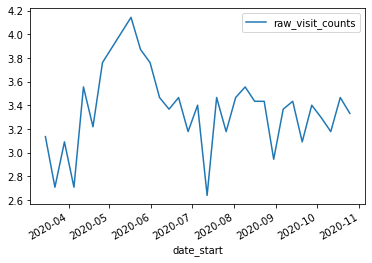

In [232]:
np.log(poi_1).plot()

In [198]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #rolling statistics
    movingAverage = timeseries.rolling(window=3).mean()
    movingSTD = timeseries.rolling(window=3).std()
    
    #plot rolling stats
    orig = plt.plot(timeseries, color='b', label='Original')
    orig = plt.plot(movingAverage, color='r', label='Rolling mean')
    orig = plt.plot(movingSTD, color='k', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & std')
    plt.show(block=False)
    
    # Dickey-Fuller test
    print('Dickey-fuller test results')
    dftest = adfuller(timeseries['raw_visit_counts'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '# Observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

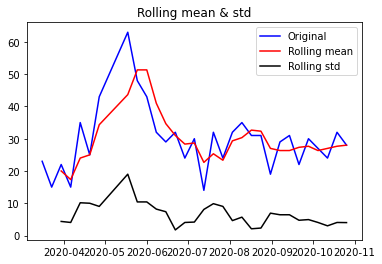

Dickey-fuller test results
Test Statistic          -2.365678
p-value                  0.151659
#Lags Used               1.000000
# Observations used     29.000000
Critical Value (1%)     -3.679060
Critical Value (5%)     -2.967882
Critical Value (10%)    -2.623158
dtype: float64


In [214]:
test_stationary(poi_1)

In [215]:
moving_avg = poi_1.rolling(window=3).mean()
minus_moving_avg = poi_1 - moving_avg
minus_moving_avg.dropna(inplace=True)

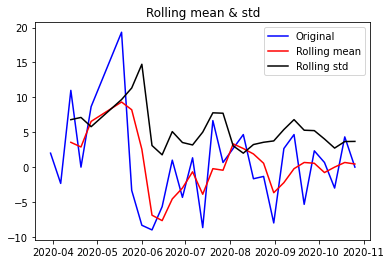

Dickey-fuller test results
Test Statistic          -4.652792
p-value                  0.000103
#Lags Used               0.000000
# Observations used     28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dtype: float64


In [216]:
test_stationary(minus_moving_avg)

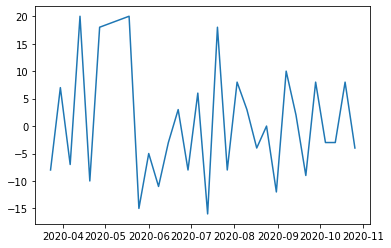

In [217]:
poi_1_shift = poi_1 - poi_1.shift()
plt.plot(poi_1_shift)

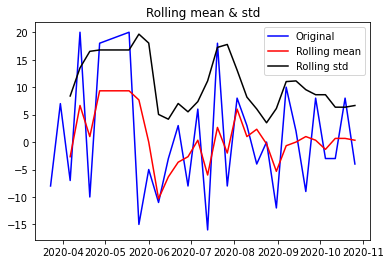

Dickey-fuller test results
Test Statistic         -8.327048e+00
p-value                 3.448055e-13
#Lags Used              0.000000e+00
# Observations used     2.900000e+01
Critical Value (1%)    -3.679060e+00
Critical Value (5%)    -2.967882e+00
Critical Value (10%)   -2.623158e+00
dtype: float64


In [218]:
poi_1_shift.dropna(inplace=True)
test_stationary(poi_1_shift)

In [229]:
poi_1['date_start']-pd.Timedelta('1 day')

0       2020-03-15
1612    2020-03-22
3190    2020-03-29
4754    2020-04-05
6325    2020-04-12
7873    2020-04-19
9444    2020-04-26
11029   2020-05-17
12645   2020-05-24
14257   2020-05-31
15880   2020-06-07
17498   2020-06-14
19120   2020-06-21
20739   2020-06-28
22371   2020-07-05
24001   2020-07-12
25635   2020-07-19
27271   2020-07-26
28940   2020-08-02
30623   2020-08-09
32311   2020-08-16
34009   2020-08-23
35711   2020-08-30
37478   2020-09-06
39232   2020-09-13
40995   2020-09-20
42758   2020-09-27
44515   2020-10-04
46319   2020-10-11
48123   2020-10-18
49927   2020-10-25
Name: date_start, dtype: datetime64[ns]

In [266]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(poi_1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(poi_1, label='Original')
plt.subplot(412)
plt.plot(trend, label='trend')
plt.subplot(411)
plt.plot(seasonal, label='seasonal')
plt.subplot(411)
plt.plot(residual, label='residual')
plt.tight_layout()

ValueError: x must have 2 complete cycles requires 104 observations. x only has 33 observation(s)

In [221]:
poi_1

,raw_visit_counts
date_start,
2020-03-16,23
2020-03-23,15
2020-03-30,22
2020-04-06,15
2020-04-13,35
2020-04-20,25
2020-04-27,43
2020-05-18,63
2020-05-25,48
